### Biodiversity Python Project by Albert Cort Banke
_____________________________________________________________________________________________________________________________________________

Project scope

***Goal***: To draw insights from the biodiversity data included and illustrate interesting features by answering questions with visualizations and summary statistics

***Data***: There are two datasets. One is data about species and the other is data about observations of different species in national parks 

***Analysis***: We use exploratory data analysis and hypothesis testing to assess the data and determine associations in the data.

***Questions***: In what ways do species represent biodiversity? What parks have the most biodiversity? Why?

_____________________________________________________________________________________________________________________________________________

**1. Preparation**

Import the relevant libraries (A) and import and read the data (B)

In [2]:
# (A)
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# (B)
species = pd.read_csv('species_info.csv')

obs = pd.read_csv('observations.csv')

# We print the first few observations to check the data has been imported correctly

print(species.head())
print(obs.head())

# The datasets look correct at first glance, however, in the species dataset the conservation_status column is apparently blank.
# Moreover, the common_names column contains multiple names for the scientific_name. This is important to note

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  
            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               

In [4]:
# Check for missing values in the datasets

print(species.info())

# The conservation-status has an overload of missing entries. The other columns in the species dataset are complete 

print(obs.info())

# The observation dataset is complete. No missing values are present 

# From the two info() headers we see that most of the data has an object datatype. One is an int64, or, a quantative variable. 
# This means most of the data is strings or text
# This is important to note beacause it affects which visualisations and statistics are wise to use 

print(species.conservation_status.unique())

# The unique values for this column is 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery' and 'nan'. 
# The 'nan' value could represent a missing value, but perhaps it could represent a condition status that is not on the current axis. 
# This could be a an indication 'Good' or 'Thriving' for example. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB
None
[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


2. Data transformation

Prepare (C) the dataset and review (D) it for the exploratory data analysis

In [5]:
# (C) Prepare the dataset by addressing their originality

print(obs.scientific_name.is_unique) # Prints false - this means we have multiple instances of the same scientific_name
print(obs.park_name.is_unique) # Prints false - this means we have multiple instances of the same park_name

# We can now assume that we have species being observed across different parks with different observation numbers
# A simple but strong assumption. Important for merging the two datasets
# Were gonna pivot the column values in the park_name column into columns 
# Then were going to create a total observations column

obs = obs.pivot_table(index = 'scientific_name', columns = 'park_name', values = 'observations', aggfunc = np.sum)

obs = pd.DataFrame(obs.to_records()) #flattening the dataframe

obs['total_observations'] = obs['Bryce National Park'] + obs['Great Smoky Mountains National Park'] + obs['Yellowstone National Park'] + obs['Yosemite National Park']

# drop any duplicates in the species dataframe

species.drop_duplicates('scientific_name', inplace = True)

print(species.scientific_name.is_unique) # prints true - this means we have unique values for the scientific_name column

# Preparing the dataset by merging it. We can do so beacuse of the scientific_name column existing in both datasets and its uniqueness. 

biodiversity = pd.merge(
    species,
    obs,
    on = 'scientific_name',
    how = 'inner'
)

# Check to see if the merge is correct

print(biodiversity.head()) # Looks good. We see the columns and now we check the vitals

print(biodiversity.scientific_name.is_unique) # Prints true - this means we have unique values for the scientific_scientific column

False
False
True
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  \
0                           Gapper's Red-Backed Vole                 NaN   
1                              American Bison, Bison                 NaN   
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN   
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN   
4                                      Wapiti Or Elk                 NaN   

   Bryce National Park  Great Smoky Mountains National Park  \
0                  130                                   98   
1                   68                                   77   
2                   99                                   56   
3  

<Figure size 720x432 with 0 Axes>

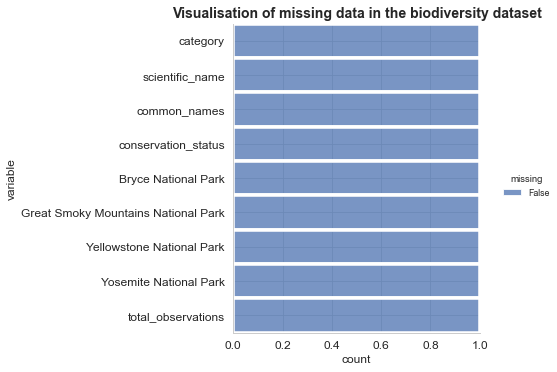

<Figure size 432x288 with 0 Axes>

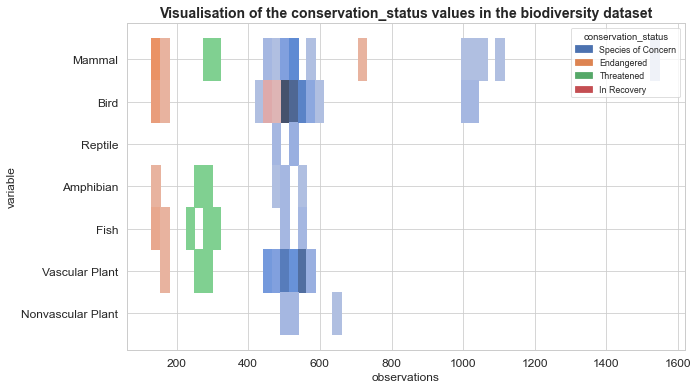

<Figure size 432x288 with 0 Axes>

In [10]:
# (D) Review the dataset by looking at its vitals and the summary statistics 

# First and foremost, we need to do something about the NaN's (missing values). Most conservation_status classifications are empty.

sns.color_palette('husl')
sns.set(style = 'whitegrid', font_scale = 1.5)
sns.set_context('paper')

plt.figure(figsize=(10,6))
sns.displot(data = biodiversity.isna().melt(value_name="missing"),
            y='variable',
            hue = 'missing',
            multiple='fill',
            aspect=1.25
            )

plt.title('Visualisation of missing data in the biodiversity dataset', fontsize= 14, fontweight="bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('count', fontsize = 12)
plt.ylabel('variable', fontsize = 12)

plt.show()
plt.clf()

# A lot of missing data as confirmed by the initial inspection. To further see the gaps we code the below hist

plt.figure(figsize=(10,6))

sns.histplot(biodiversity, x='total_observations', y = 'category', hue = 'conservation_status', legend=True)

plt.title('Visualisation of the conservation_status values in the biodiversity dataset', fontsize= 14, fontweight="bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('observations', fontsize = 12)
plt.ylabel('variable', fontsize = 12)

plt.show()
plt.clf()

<Figure size 720x432 with 0 Axes>

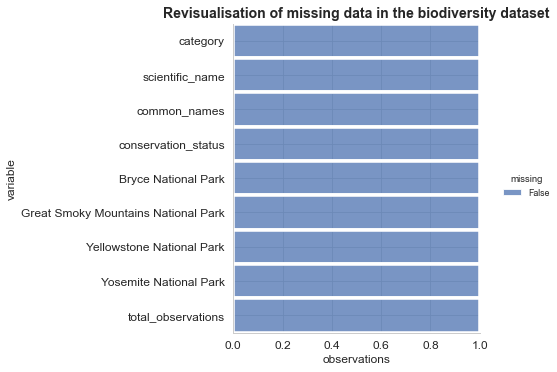

<Figure size 432x288 with 0 Axes>

In [7]:
# The above graph highlight some interesting patterns for the conservation status
# Lets remove the null rows to clean up the dataset. This is a major tradeoff as we neglect over 90% of the dataset
# However, we hold true to the origin of the data and thus enable the conclusions witout comprimising external reliability

biodiversity = biodiversity.dropna()

plt.figure(figsize=(10,6))
sns.displot(data = biodiversity.isna().melt(value_name="missing"),
            y='variable',
            hue = 'missing',
            multiple='fill',
            aspect=1.25
            )

plt.title('Revisualisation of missing data in the biodiversity dataset', fontsize= 14, fontweight="bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('observations', fontsize = 12)
plt.ylabel('variable', fontsize = 12)


plt.show()
plt.clf()

# We see that the conservation_status variable is now complete as well as the dataset
# The initial datatransformation is now complete. Lets check the vitals again and move on the Exploratory Data Analysis. 


3. Exploratory Data Analysis

This section consists of two parts. The first is a summary (E) of the statistical aspects of the data. The second is visualization (F) module, which consists of univariate, bivariate, and multivariate analysis.  

In [8]:
# (E) Summary statistics with Pandas .describe() function

print(biodiversity.describe())

       Bryce National Park  Great Smoky Mountains National Park  \
count           178.000000                           178.000000   
mean             90.443820                            62.792135   
std              37.710459                            28.620575   
min              20.000000                            11.000000   
25%              73.250000                            45.250000   
50%              92.000000                            61.500000   
75%             105.000000                            78.000000   
max             298.000000                           174.000000   

       Yellowstone National Park  Yosemite National Park  total_observations  
count                 178.000000              178.000000          178.000000  
mean                  217.207865              131.213483          501.657303  
std                    78.823170               49.142471          181.295715  
min                    57.000000               31.000000          131.000000  
2

Interpretation of the statistics

First one should notice that the code only present us with the quantitative variables. 

***Parks:*** The new amount of data in our dataset is 178 instances. Moreover Yellowstone National Park holds the most observations for species with a classified conservation_status. Remember, we removed the NaN values. Subsequently the Great Smoky Moutains National Park have 62 average observations. This makes it the park with the least observations per species. 

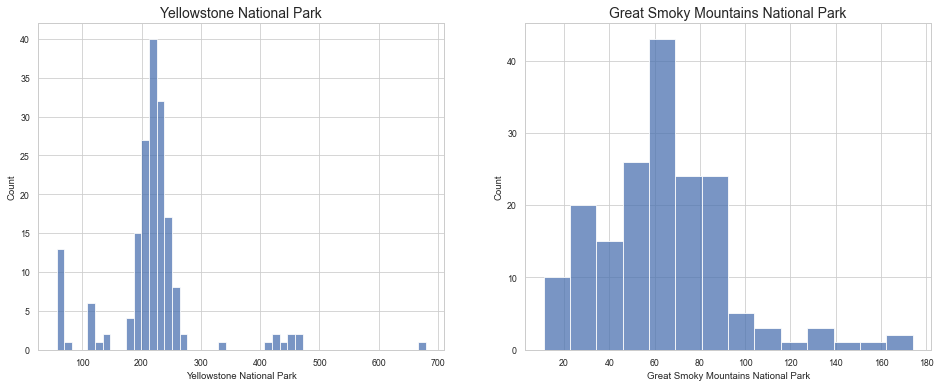

<Figure size 432x288 with 0 Axes>

In [9]:
# (F) Univariate data analysis

# Plotting a histogram of the above two parks

plt.figure(figsize = [16, 6])

plt.subplot(1, 2, 1)
ax = sns.histplot(data = biodiversity, x='Yellowstone National Park')

plt.title('Yellowstone National Park', fontsize = 14)

# Interpretation: The histogram has quite some distance between the largest and smallest observations. Looking back at the st. dev we see size of 78.28. Largest of all parks.
# This could indicate that the park hosts many different species (mammals, plants etc.) This could also indicate outliers of species not present in other parks. 

plt.subplot(1, 2, 2)

ax1 = sns.histplot(data = biodiversity, x='Great Smoky Mountains National Park')
plt.title('Great Smoky Mountains National Park', fontsize = 14)
plt.show()
plt.clf()

# Interpretation: The GDP variable is right-skewed. We do not have normal distributions in either of the graphs. This is important to note, and could be due to sampling issues
# This indicates that there are outliers. 